In [2]:
import itertools as it
from glob import glob
import cv2
import numpy as np
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import tifffile as tf

from scipy import ndimage, signal, spatial
from skimage import morphology

import os
import pandas as pd

from importlib import reload

import sklearn.linear_model as linear

In [3]:
maize_palettes = {
  'Anthocyanins1':["#f8f1d9", "#edc262", "#9a3a28", "#581d2c", "#2e1342"],
  'Anthocyanins2':["#f4e8a7", "#e7a96f", "#b05732", "#6a3131", "#2f2929"],
  'RubyGold':["#57170f", "#943124", "#eabf5a", "#f4e093", "#edaa5d", "#e77e39"],
  'Sweetest':["#b2c66b", "#696d2e", "#f9f2b2", "#f1cf62", "#6f4d22"],
  'GlassGem':["#d1aae6", "#6c5ba5", "#e66e58", "#7f346f", "#9d2315"],
  'PodCorn':["#b28044", "#debc80", "#f1dfda", "#dac9ae", "#988e79"],
  'HighlandMAGIC':["#d73c6c", "#db86a5", "#f2cb5d", "#faebb6", "#914d8f", "#4b1f96"],
  'MaizAzul':["#160d23", "#6e79a2", "#acb1d1", "#e2e7e9", "#9b969c", "#384073"],
  'JimmyRed':["#61241c", "#b66859", "#d59578", "#f1deda", "#ddbb7f", "#a04230"],
  'FloweringTime':["#933141", "#d1aac5", "#f1e89f", "#c1cb68", "#7c7c46", "#626d5c"],
  'HopiBlue':["#763a4e", "#a192ac", "#fcf3ba", "#d4af55", "#607e91", "#28344f"],
  'Painted':["#e77e39", "#9e5727", "#efc164", "#a27937", "#e66e58", "#9d462f"],
  'MaizMorado':["#100708", "#6F0E2E", "#BC184E", "#D77495", "#E4B9C7"],
  'OaxacaGreen':["#CAC67A", "#426F4D", "#213827", "#2C5273", "#817A35"]
}
markers = ['s','D','o','^','v','<','>','*']

In [23]:
boundary = ndimage.generate_binary_structure(2,2).astype(int) - 2
boundary[1,1] = -(np.sum(boundary) + 1)
unique = np.array([40, 120, 160, 200, 240], dtype=np.uint8)

struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)

rsrc = '../raw/'
src = '../proc/'
dst = src + 'results/'
time = '12pm'
rep = 1
pidx = 3

foo = '_rep{}/plant_{:02d}/'.format(rep,pidx)

asrc = src + 'anchory/' + time + foo
psrc = src + 'prelim/' + time + foo

filenames = glob(psrc + '*.tif')

nums = np.zeros(len(filenames), dtype=int) - 1
for i in range(len(nums)):
    num = os.path.splitext(os.path.split(filenames[i])[1])[0].split('_')[-1]
    num = int(num)
    nums[i] = num
        
anums = np.argsort(nums)

In [24]:
deets = []
maxL = 0

for idx in range(len(anums)):
#for idx in range(10):
    
    img = tf.imread(filenames[anums[idx]])
    
    metafile = asrc + os.path.splitext(os.path.split(filenames[anums[idx]])[1])[0] + '.csv'
    meta = pd.read_csv(metafile, header = None)
    lenraw = meta.iloc[0,0]
    tape = meta.iloc[0,2]
    peak = meta.iloc[0,3]
    buffx = meta.iloc[0,4]
    buffy = meta.iloc[0,5]

    plant = meta.iloc[0, 6:10].values.astype(int)
    ceros = meta.iloc[0, 10:14].values.astype(int)
    coef = meta.iloc[0,15:].values
    pss = np.s_[plant[0]:plant[1], plant[2]:plant[3]]

    rawx = ceros[2] + plant[2] - peak + buffy
    rawy = ceros[0] + plant[0] + buffx
    
    xvals = np.arange(lenraw)
    b0 = peak + coef[0] - buffy
    lines = b0 + coef[1]*(xvals - buffx)

    line = lines[ pss[0] ] - plant[2]
    ll = line[np.arange(ceros[0],ceros[1])] - ceros[2]

    
    v0 = np.array([coef[1], 1])
    v = v0/np.linalg.norm(v0)
    n = np.array([-v[1], v[0]])
    p = np.array([ll[0],0])
    b = np.sum(p*n)

    cross = np.asarray(np.nonzero(img > 180))
    dist = np.abs(cross[1]*n[0] + cross[0]*n[1] - b)
    mask = dist < 10
    
    if np.sum(mask) > 5:
        skel = np.zeros(img.shape, dtype=bool)
        skel[cross[0, mask], cross[1, mask]] = True
        labels,num = ndimage.label(skel, structure=ndimage.generate_binary_structure(2,2))
        hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
        where = np.nonzero((hist/np.sum(hist) > 0.1))[0]
        
        if len(where) > 1:
            merged = dict()
            coords = dict()
            for i in range(len(where)):
                coords[where[i]] = np.asarray(np.nonzero(labels == where[i] + 1))
                merged[where[i]] = []

            combs = list(it.combinations(where, 2))
            for i in range(len(combs)):
                dxy = np.min(spatial.distance.cdist(coords[combs[i][0]].T, coords[combs[i][1]].T, metric='euclidean'))

                if dxy < 20:
                    merged[combs[i][1]].append(combs[i][0])

            for j,i in enumerate(where):
                k = i  
                while len(merged[k]) > 0:
                    k = min(merged[k])
                
                labels[labels == i+1] = k+1
                where[j] = k

            where = np.unique(where)
        
        coms = np.asarray(ndimage.center_of_mass(skel, labels, where+1))
        angle = np.zeros(len(coms))
        dmask = []
        dcom = []

        for i in range(len(coms)):
            com = coms[i]
            dd = np.sqrt(np.sum((cross - com.reshape(-1,1))**2, axis=0))
            foo = dd < 40
            dmask.append(foo)
            foo = dd[dmask[i]]
            dcom.append(np.max(foo) + 1 - foo)

            X = cross[1, dmask[i]].reshape(-1,1)
            reg = linear.RANSACRegressor(random_state=0).fit(X, cross[0,dmask[i]], sample_weight = dcom[i])
            coef1 = np.diff(reg.predict([[0],[1]]))[0]
            w0 = np.array([1, coef1])
            w = w0/np.linalg.norm(w0)

            angle[i] = -np.sign(coef1)*np.arccos(np.abs(np.sum(w*n)))
        
        if len(coms) > maxL:
            maxL = len(coms)
        deet = dict()
        deet['idx'] = nums[anums[idx]]
        deet['comsx'] = coms[:,1]+rawx
        deet['comsy'] = coms[:,0]+rawy
        deet['tape'] = tape
        deet['raw'] = np.array([rawx,rawy])
        deet['angles'] = np.rad2deg(angle)
        
        deets.append(deet)
        
print(maxL)

2


In [14]:
idx

901

In [25]:
print('First coil at timestamp:\t',deets[0]['idx'])
for sidx in range(len(deets)):
    if len(deets[sidx]['angles']) > 1:
        break
print('Second coil at timestamp:\t',deets[sidx]['idx'])

First coil at timestamp:	 36
Second coil at timestamp:	 36


In [16]:
deets[sidx]

{'idx': 198,
 'comsx': array([195.5, 205.5]),
 'comsy': array([ 645.3 , 1167.85]),
 'tape': 1176,
 'raw': array([ 47, 625]),
 'angles': array([8.16791435, 1.41380743])}

In [26]:
pos = np.zeros((len(deets), 1+maxL))
ang = np.zeros((len(deets), 1+maxL))

for i in range(len(pos)):
    pad = maxL - len(deets[i]['comsy'])
    pos[i,0] = deets[i]['idx']
    pos[i, 1:] = np.pad(deets[i]['tape'] - deets[i]['comsy'], (pad,0))
    
    ang[i,0] = deets[i]['idx']
    ang[i, 1:] = np.pad(deets[i]['angles'], (pad,0))

pos = pos.T
ang = ang.T

In [18]:
deets[np.argmax(np.ediff1d(ang[j]))+1]

{'idx': 299,
 'comsx': array([181.2       , 187.02105263, 188.73611111]),
 'comsy': array([427.02857143, 541.        , 666.5       ]),
 'tape': 1119,
 'raw': array([104, 405]),
 'angles': array([ 64.02611035, -75.28103044,  73.73437029])}

In [27]:
j = 1
mask = pos[j] > 0
ang[0, mask]

array([ 36., 278., 279., 280., 281., 282., 283., 284., 285., 286., 287.,
       288., 289., 290., 291., 292., 293., 294., 295., 296., 297., 298.,
       299., 300., 301., 302., 303., 304., 305., 306., 307., 308., 309.,
       310., 311., 312., 313., 314., 315., 316., 317., 318., 319., 320.,
       321., 322., 323., 324., 325., 326., 327., 328., 329., 330., 331.,
       332., 333., 334., 335., 336., 337., 338., 339., 340., 341., 342.,
       343., 344., 345., 346., 347., 348., 349., 350., 351., 352., 353.,
       354., 355., 356., 357., 358., 359., 360., 361., 362., 363., 364.,
       365., 366., 367., 368., 369., 370., 371., 372., 373., 374., 375.,
       376., 377., 378., 379., 380., 381., 382., 383., 384., 385., 386.,
       387., 388., 389., 390., 391., 392., 393., 394., 395., 396., 397.,
       398., 399., 400., 401., 402., 403., 404., 405., 406., 407., 408.,
       409., 410., 411., 412., 413., 414., 415., 416., 417., 418., 419.,
       420., 421., 422., 423., 424., 425., 426., 42

In [20]:
i = 161
deets[i]

{'idx': 360,
 'comsx': array([190.77272727]),
 'comsy': array([727.5]),
 'tape': 1121,
 'raw': array([122, 651]),
 'angles': array([45.39442012])}

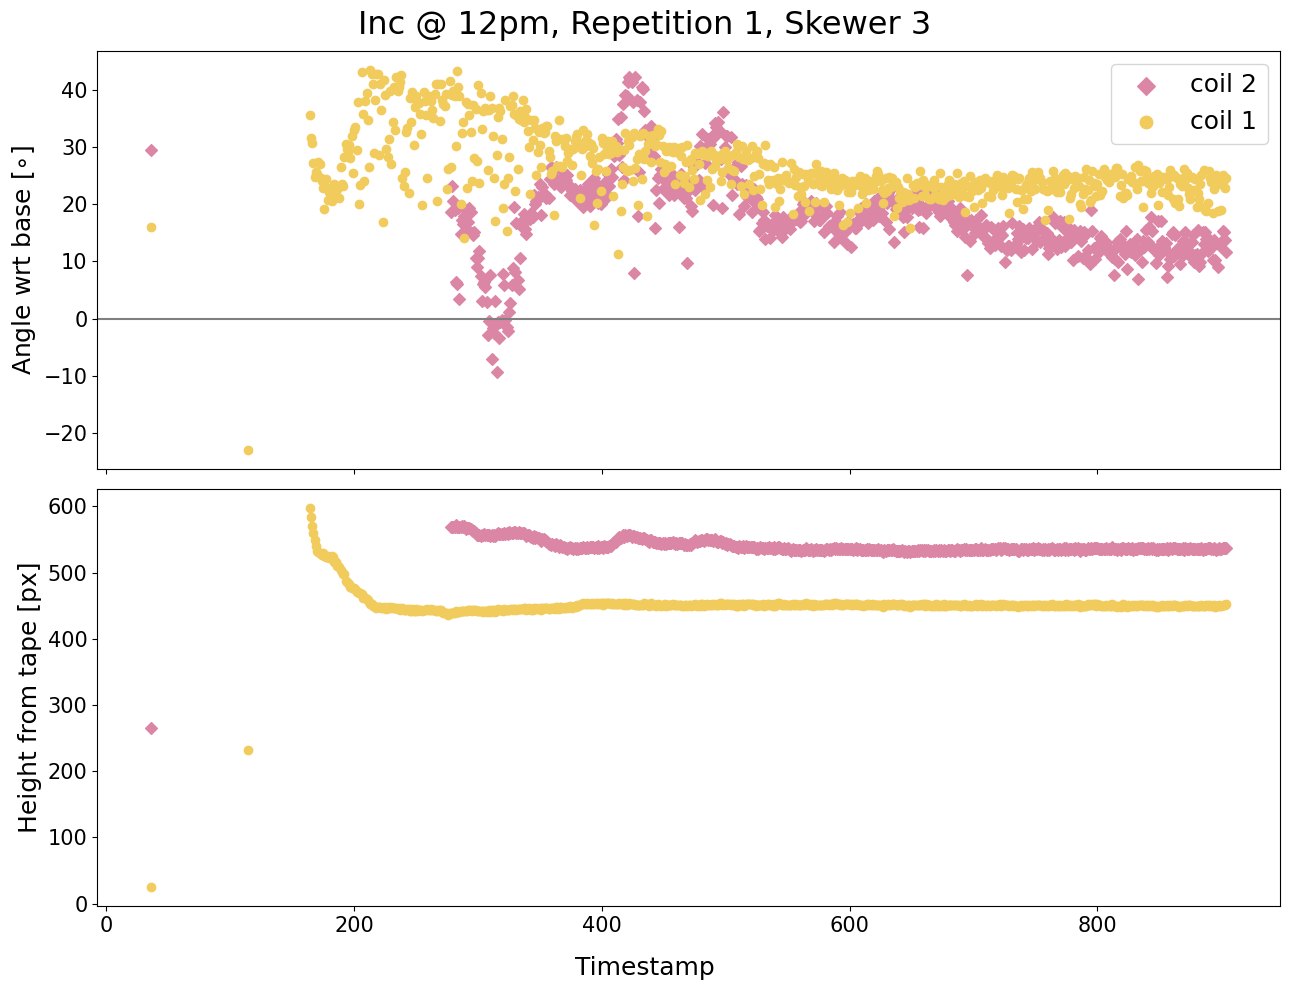

In [28]:
colors = maize_palettes['HighlandMAGIC']

fs = 18
fig, ax = plt.subplots(2,1,figsize=(13,10), sharex=True, sharey=False)
ax = np.atleast_1d(ax).ravel()

for j in range(1, len(pos)):
    mask = pos[j] > 0
    label = 'coil {}'.format(maxL + 1 - j)
    ax[0].scatter(ang[0, mask], ang[j, mask], c=colors[j], marker=markers[j], label=label)
    ax[1].scatter(pos[0, mask], pos[j, mask], c=colors[j], marker=markers[j])

ax[0].legend(fontsize=fs, markerscale=1.5);
ax[0].axhline(0, c='gray')

for i in range(len(ax)):
    ax[i].tick_params(labelsize=fs-3)
    #ax[i].axvline(450)

ax[0].set_ylabel('Angle wrt base [$\circ$]', fontsize=fs)
ax[1].set_ylabel('Height from tape [px]', fontsize=fs)

fig.supxlabel('Timestamp', fontsize=fs)
fig.suptitle('Inc @ {}, Repetition {}, Skewer {}'.format(time, rep, pidx), fontsize=fs+5)
fig.tight_layout()

filename = dst + time + '_rep{}_plant_{:02d}'.format(rep,pidx)
plt.savefig(filename + '.png', dpi=100, format='png', pil_kwargs={'optimize':True}, bbox_inches='tight')

In [82]:
filename = dst + time + '_rep{}_plant_{:02d}'.format(rep,pidx)
filename

'../proc/results/4pm_rep7_plant_04'

In [243]:
img = np.zeros((250, 100), dtype=bool)
img[:, 35:65] = True

i = 575

for i in range(0,len(deets),5):
    d = deets[i]
    xy1 = np.array([50, 175]).astype(float)
    if len(d) > 0:
        fig, ax = plt.subplots(1,1,figsize=(4, 10), sharex=True, sharey=False)
        ax = np.atleast_1d(ax).ravel()

        ax[0].imshow(img, cmap='inferno');
        ax[0].set_xlim(0,99)
        ax[0].margins(0)
        ax[0].axis('off')

        if len(d['size']) == 1:
            m1 = d['poly'][0,1]
            ax[0].plot((33, 67), (xy1[1] - 17*m1, xy1[1]+17*m1), c='red', lw=5)
        else:
            foo = d['order']
            m1 = d['poly'][foo[0],1]
            m2 = d['poly'][foo[1],1]
            xy2 = xy1.copy()
            xy2[1] -= np.abs(np.ediff1d(d['vpos'])[0])*.35
            
            ax[0].plot((33, 67), (xy1[1] - 17*m1, xy1[1]+17*m1), c='red', lw=5)
            ax[0].plot((33, 67), (xy2[1] - 17*m2, xy2[1]+17*m2), c='blue', lw=5)
            ax[0].plot((33, 67), (xy2[1] - 17*m2, xy1[1]+17*m1), c='gray', lw=5, ls='--')

            
        filename = '../proc/anim/' + time + '_rep{}_p{:02d}_{:04d}'.format(rep,pidx,i)
        plt.savefig(filename + '.png', dpi=72, format='png', bbox_inches='tight', pad_inches=0)
        plt.close() 